In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Focus/Code'
%ls

/content/drive/MyDrive/Focus/Code
 data_preprocessing.ipynb   EfficientNet_B3_A.ipynb   NASNetMobile_B.ipynb
'DenseNet(169)_A.ipynb'     EfficientNet_B3_B.ipynb
'DenseNet(169)_B.ipynb'     NASNetMobile_A.ipynb


In [3]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.applications import NASNetMobile
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
batch_size = 32
dataset_code = 'A'
model_name = 'NASNetMobile'
data_saved_dir = r'/content/drive/MyDrive/Focus/Dataset'
model_saved_dir = r'/content/drive/MyDrive/Focus/Models'
train_data_path = f'{data_saved_dir}/A_training.pkl'
val_data_path = f'{data_saved_dir}/A_validation.pkl'
test_data_path = f'{data_saved_dir}/A_testing.pkl'

In [5]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_images, train_labels = load_pickle(train_data_path)
val_images, val_labels = load_pickle(val_data_path)
test_images, test_labels = load_pickle(test_data_path)

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: (3718, 256, 256, 3)
Validation images: (795, 256, 256, 3)
Testing images: (801, 256, 256, 3)


In [6]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)
test_data_generator = CustomDataGenerator(test_images, test_labels, batch_size)

In [7]:
efficient_net = NASNetMobile(
    weights='imagenet',
    input_shape=(256,256,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(Input(shape=(256, 256, 3)))
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)           │ (None, 1056)                │       4,269,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │         126,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          14,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,411,197 (16.83 MB)

 Trainable params: 4,374,459 (16.69 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

model_dir = f'{model_saved_dir}/{dataset_code}_{model_name}'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    print(f'{model_dir} already exists')

filename = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}'
# Change the file extension to .keras
filepath = f'{model_dir}/{dataset_code}_{model_name}-{filename}.keras'

# Define the ModelCheckpoint with the corrected filepath
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Add callbacks to the list
callbacks_list = [checkpoint, early_stop]

In [9]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator, callbacks = callbacks_list)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9372 - loss: 0.2935
Epoch 1: val_accuracy improved from -inf to 0.91069, saving model to /content/drive/MyDrive/Focus/Models/A_NASNetMobile/A_NASNetMobile-weights-improvement-01-0.91.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9374 - loss: 0.2924 - val_accuracy: 0.9107 - val_loss: 0.2548
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9753 - loss: 0.0778
Epoch 2: val_accuracy did not improve from 0.91069
117/117 ━━━━━━━━━━━━━━━━━━━━ 32s 274ms/step - accuracy: 0.9753 - loss: 0.0779 - val_accuracy: 0.8931 - val_loss: 3.3846
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9833 - loss: 0.0609
Epoch 3: val_accuracy improved from 0.91069 to 0.92327, saving model to /content/drive/MyDrive/Focus/Models/A_NASNetMobile/A_NASNetMobile-weights-improvement-03-0.92.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 44s 300ms/step - accuracy: 0.9832 - loss: 0.0610 - val_accuracy: 0.9233 - val_loss: 0.3865


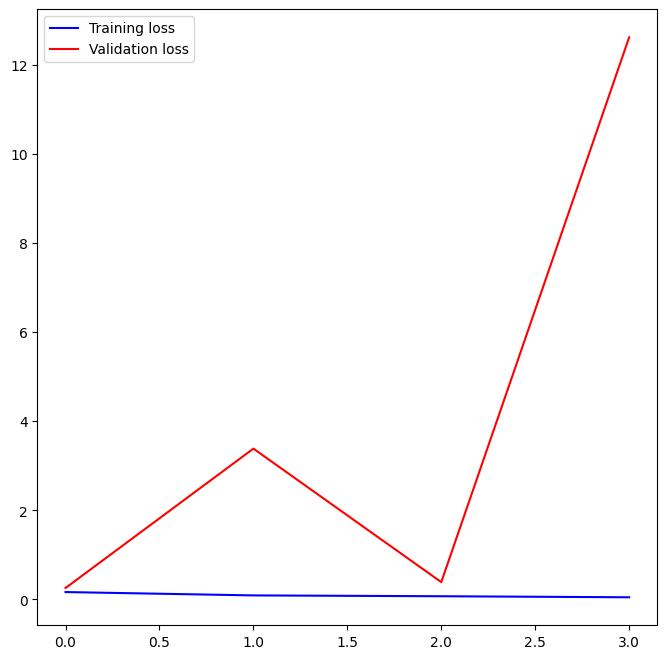

<Figure size 640x480 with 0 Axes>

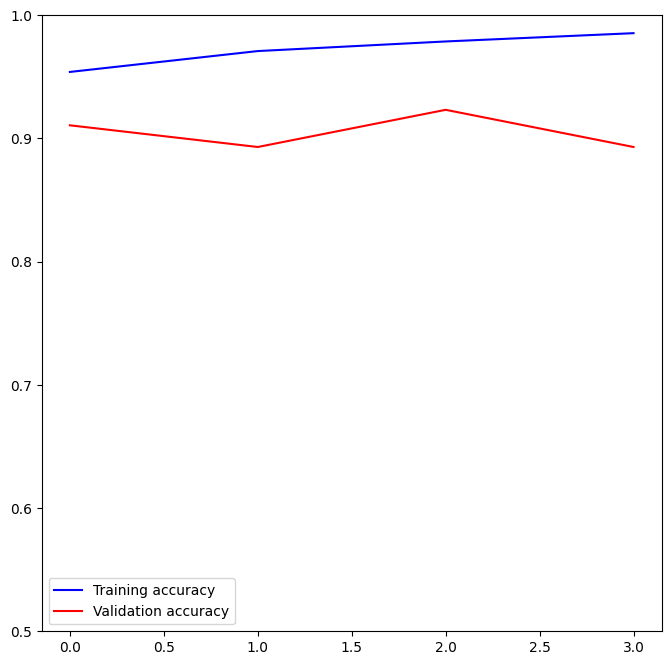

In [10]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

#### Testing on model till Last Epoch

Best model loaded ...
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 609ms/step


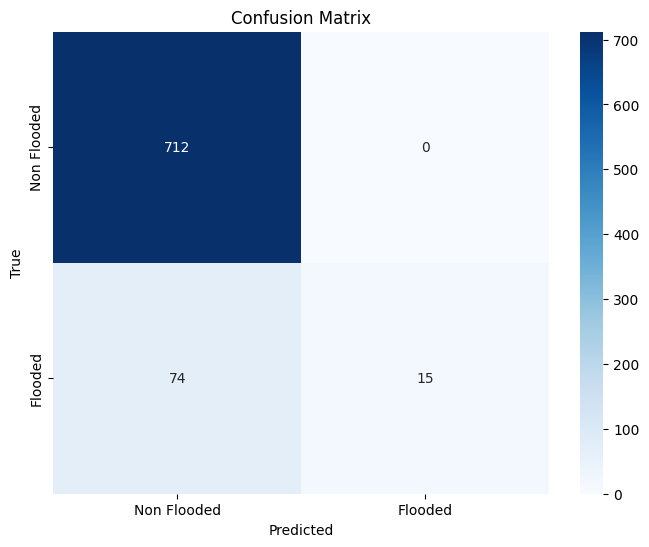

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       712
           1       1.00      0.17      0.29        89

    accuracy                           0.91       801
   macro avg       0.95      0.58      0.62       801
weighted avg       0.92      0.91      0.88       801



In [10]:
best_model = load_model(f'/content/drive/MyDrive/Focus/Models/A_NASNetMobile/A_NASNetMobile-weights-improvement-03-0.92.keras')
print('Best model loaded ...')

predictions = best_model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))